In [3]:
#
# Working through
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_7_conc_input_conf_k_aug.py
#

In [2]:
from kipet import KipetModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
filename = '/home/paperspace/learn_kipet/my_data_sets/ABC_data.csv'
C_data = pd.read_csv(filename, index_col = 0)
C_data.columns = ['A', 'B', 'C']
C_data

,A,B,C
t,,,
0.000,0.957,-0.031,-0.015
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454
1.316,0.079,0.396,0.556
1.579,0.035,0.303,0.651
1.842,0.029,0.287,0.658
2.105,0.025,0.221,0.750


In [18]:
mdl = KipetModel()

r1 = mdl.new_reaction('rxn1')

r1.add_component('A', state = 'concentration', init = 1.0, variance = 1)
r1.add_component('B', state = 'concentration', init = 0.0, variance = 1)
r1.add_component('C', state = 'concentration', init = 0.0, variance = 1)

r1.add_parameter('k1', init = 5.0, bounds = (0.0, 10.0))
r1.add_parameter('k2', init = 5.0, bounds = (0.0, 10.0))

In [19]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

r1.add_equations(rule_odes)
r1.set_times(0.0, 5.0)

In [20]:
r1.add_dataset('C_data', category = 'concentration', data = C_data)

In [21]:
r1.settings.collocation.nfe = 50
r1.settings.collocation.ncp = 3
r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'

In [22]:
r1.run_opt()

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0.0 5.0
        0.11 seconds required to write file
        0.11 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3903
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      905
                     variables with only lower bounds

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 905
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 2
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601245992886472 at var_i=300
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60087321095033 at var_i=301
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 3903
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 360
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.026057
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 845
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]


RESULTS
Z:
                  A         B         C
0.000000  1.000000  0.000000  0.000000
0.010195  0.979627  0.020269  0.000103
0.042405  0.917944  0.080329  0.001728
0.065750  0.875681  0.120261  0.004058
0.075945  0.857841  0.136799  0.005360
...            ...       ...       ...
4.821811  0.000059  0.016274  0.983667
4.868500  0.000054  0.015542  0.984404
4.888889  0.000052  0.015233  0.984716
4.953311  0.000045  0.014295  0.985660
5.000000  0.000041  0.013651  0.986307

[151 rows x 3 columns]

Cm:
            A      B      C
0.000  0.957 -0.031 -0.015
0.263  0.557  0.330  0.044
0.526  0.342  0.512  0.156
0.789  0.224  0.499  0.310
1.053  0.123  0.428  0.454
1.316  0.079  0.396  0.556
1.579  0.035  0.303  0.651
1.842  0.029  0.287  0.658
2.105  0.025  0.221  0.750
2.368  0.017  0.148  0.854
2.632 -0.002  0.182  0.845
2.895  0.009  0.116  0.893
3.158 -0.023  0.079  0.942
3.421  0.006  0.078  0.899
3.684  0.016  0.059  0.942
3.947  0.014  0.036  0.991
4.211 -0.009  0.014  0.988
4.4

In [23]:
print("The estimated parameters are:")
# Display the results
r1.results.show_parameters

The estimated parameters are:

The estimated parameters are:
k1 2.0190605328903306
k2 0.9929746215441738


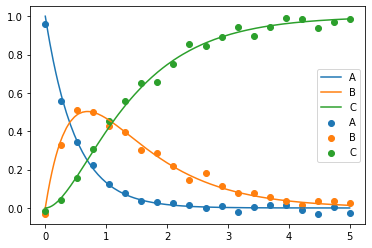

In [25]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.scatter(r1.results.Cm.index, r1.results.Cm[c], label = c)
    ax.plot(r1.results.Z.index, r1.results.Z[c], label = c)
ax.legend()

In [24]:
dof = r1.results.Cm.shape[0] * 3 - 2
cov_mat = r1.results.objective / dof * r1.results.parameter_covariance
cov_mat

array([[ 0.00115467, -0.00017625],
       [-0.00017625,  0.00015515]])